In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [47]:
def analysis(data: pd.DataFrame):
    data['date_time'] = pd.to_datetime(data['date_time'])
    month = data['date_time'].dt.month
    day_of_week = data['date_time'].dt.dayofweek
    hour = data['date_time'].dt.hour
    date = data['date_time'].dt.date
    

    print('DATE ANALYSIS\n')
    print(f'dates in dataset: \n{date.value_counts()}\n\n')

    ax = hour.value_counts(sort=False).sort_index().plot(kind='bar', title='hours distribution')
    plt.show()

    hours_counts_if_clicks = data[data['clicks'] == 1]['date_time'].dt.hour.value_counts(sort=False).sort_index()
    hours_counts = hour.value_counts(sort=False).sort_index()
    stat = pd.Series([h_cnt_if_cl / h_cnt for h_cnt_if_cl, h_cnt in zip(hours_counts_if_clicks, hours_counts)])
    ax = stat.plot(kind='bar', title='clicks rate per hours')
    plt.show()

    ax = day_of_week.value_counts(sort=False).sort_index().plot(kind='bar', title='day_of_week distribution')
    plt.show()

    ax = month.value_counts().plot(kind='bar', title='month distribution')
    plt.show()

    print('CLICK ANALYSIS\n')
    ax = data['impressions'].value_counts().plot(kind='bar', title='impressions distribution')
    plt.show()

    ax = data['clicks'].value_counts().plot(kind='bar', title='clicks distribution')
    plt.show()

    plt.hist(data['campaign_clicks'], bins=100, log=True)
    plt.title('campaign clicks distribution, log scale')
    plt.show()

    print('OTHER\n')
    print(f'num of unique in "zone_id": {len(np.unique(data["zone_id"]))}')
    print(f'num of unique in "banner_id": {len(np.unique(data["banner_id"]))}')
    for col in ["os_id", "country_id"]:
        ax = data[col].value_counts().plot(kind='bar', title=f'{col} distribution')
        plt.show()

DATE ANALYSIS

dates in dataset: 
2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date_time, dtype: int64




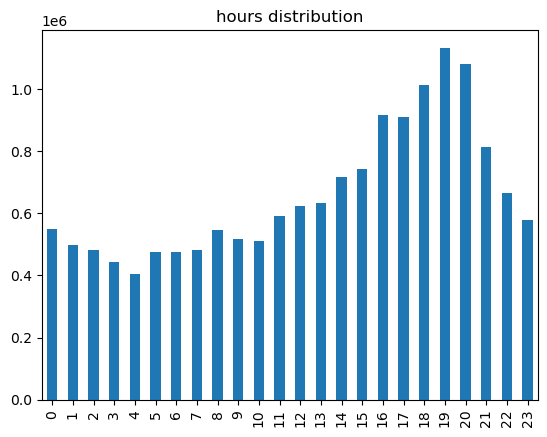

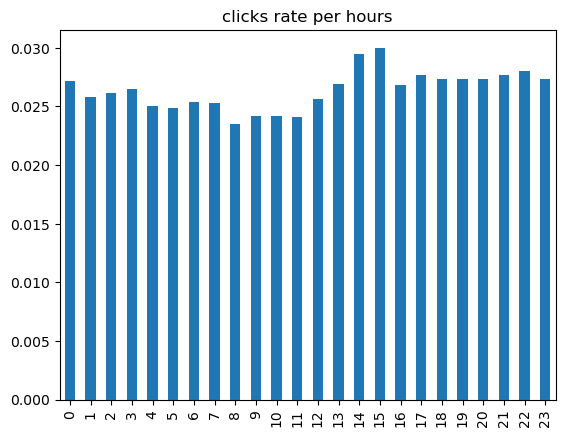

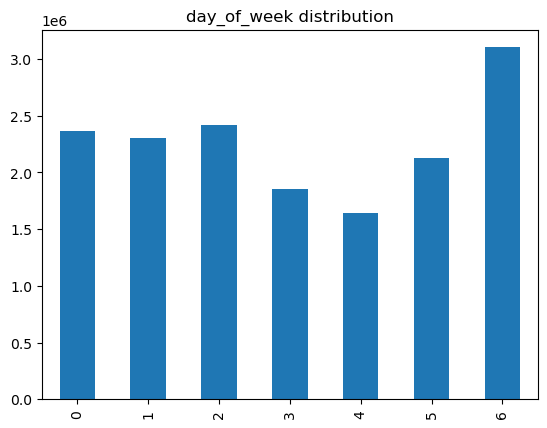

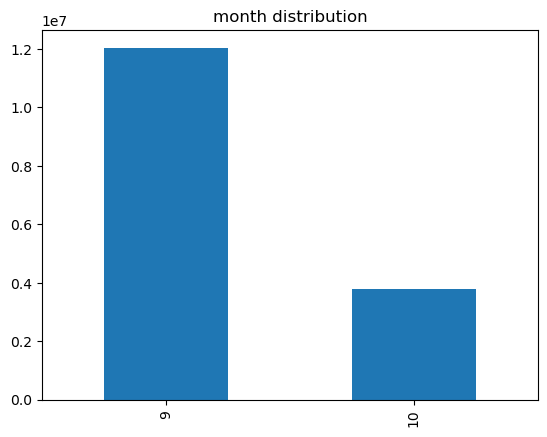

CLICK ANALYSIS



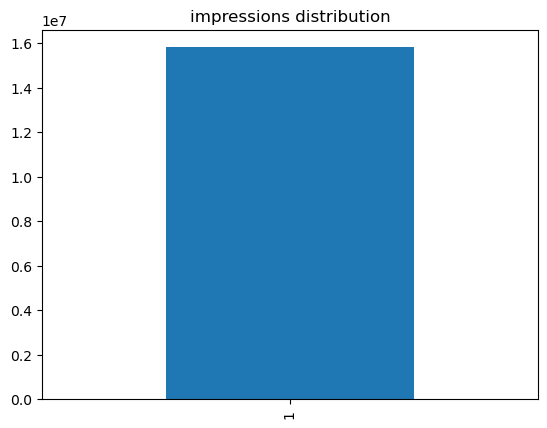

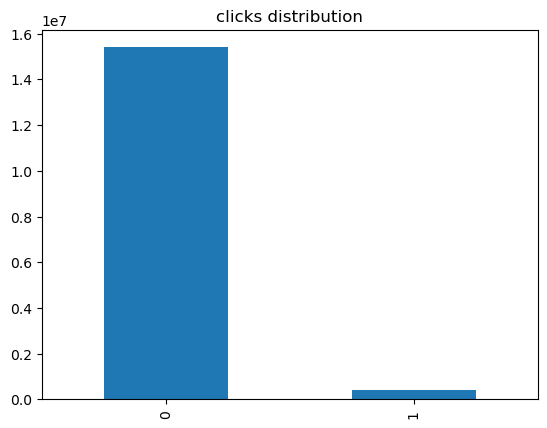

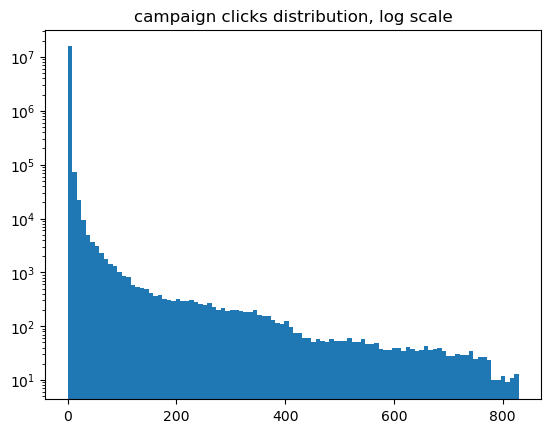

OTHER

num of unique in "zone_id": 3444
num of unique in "banner_id": 1633


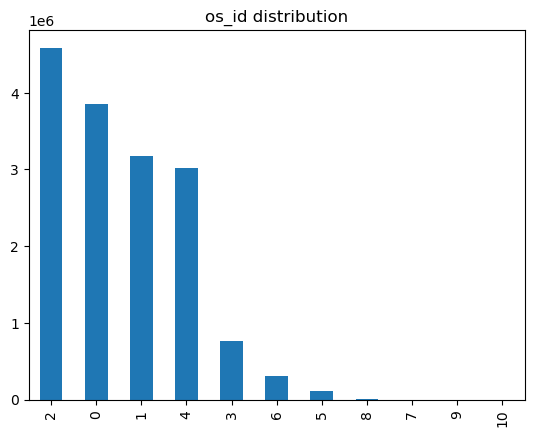

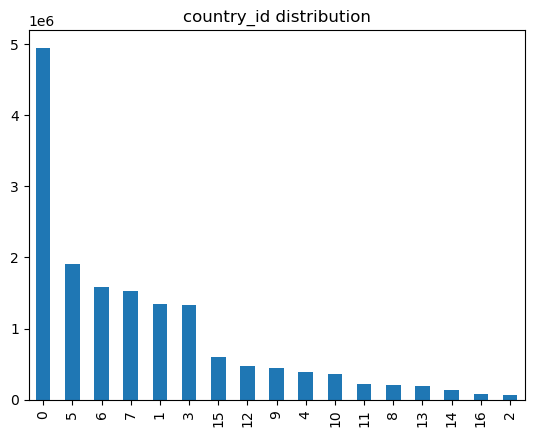

In [48]:
analysis(data)

* Можно удалить impressions
* campaign clicks требует логарифма. Т.к. это единственный не категориальный признак, я не буду делать нормализацию всех данных и остановлюсь на логарифме.
* Из всей даты полезными кажутся только дни недели и время дня. Для времени выделю два промежутка в течение дня в зависимости от популярности. Ниже можно заметить, что получаются два признака: первая половина дня (1-12) и вторая половина дня (13-23, 0). Дни недели оставлю как есть.
* zone_id и banner_id не получится уменьшить или выделить что-то из них, поэтому оставлю как есть

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

def feature_engineering(data_: pd.DataFrame):
    data = data_.copy()

    # drop features
    data = data.drop(["oaid_hash", "banner_id0", "banner_id1", "rate0", "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1", "impressions"], axis=1)

    # add log to campaign_clicks
    data['campaign_clicks'] = np.log(data['campaign_clicks'] + 1e-5)

    data['date_time'] = pd.to_datetime(data['date_time'])

    # split hour feature to two categorical features
    hours_counts_if_clicks = data[data['clicks'] == 1]['date_time'].dt.hour.value_counts(sort=False).sort_index()
    hours_counts = data['date_time'].dt.hour.value_counts(sort=False).sort_index()
    stat = [h_cnt_if_cl / h_cnt for h_cnt_if_cl, h_cnt in zip(hours_counts_if_clicks, hours_counts)]
    median = np.median(stat)
    print(f'median of hour statistic: {median}')
    print(f'hour_0: {[h for h in range(24) if stat[h] < median]}')
    print(f'hour_1: {[h for h in range(24) if stat[h] >= median]}')
    data['hour_0'] = [1 if stat[h] < median else 0 for h in data['date_time'].dt.hour]
    data['hour_1'] = [1 if median <= stat[h] else 0 for h in data['date_time'].dt.hour]

    # add day_of_week feature
    data['day_of_week'] = data['date_time'].dt.dayofweek

    # split train-test
    train = data[data['date_time'].dt.date < pd.to_datetime('2021-10-02')]
    test = data[data['date_time'].dt.date == pd.to_datetime('2021-10-02')]

    # drop data column
    train = train.drop(["date_time",], axis=1)
    test = test.drop(["date_time",], axis=1)

    # one-hot encoding
    enc = OneHotEncoder(handle_unknown='ignore')
    col_categ = ["zone_id", "banner_id", "os_id", "country_id", "day_of_week"]
    X_categ_train = enc.fit_transform(train[col_categ])
    X_categ_test = enc.transform(test[col_categ])

    X_train = hstack((X_categ_train, np.array(train["campaign_clicks"])[:, np.newaxis], np.array(train["hour_0"])[:, np.newaxis], np.array(train["hour_1"])[:, np.newaxis]))
    X_test = hstack((X_categ_test, np.array(test["campaign_clicks"])[:, np.newaxis], np.array(test["hour_0"])[:, np.newaxis], np.array(test["hour_1"])[:, np.newaxis]))

    y_train, y_test = train["clicks"], test["clicks"]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = feature_engineering(data)

Признаки: ['zone_id', 'banner_id', 'campaign_clicks', 'os_id', 'country_id', 'clicks', 'hour_0', 'hour_1', 'day_of_week']

In [72]:
from sklearn.linear_model import LogisticRegression

def create_model(C):
    model = LogisticRegression(solver='liblinear', random_state=42, C=C)
    return model

Используем логистическую регрессию, оптимизатор liblinear, регуляризация l2 по умолчанию, C подберем с помощью кросс валидации

In [82]:
from sklearn.model_selection import cross_validate

def cv(X_train, y_train):
    res = []
    for C in [0.001, 0.01, 0.1, 1]:
        model = create_model(C)
        cv = cross_validate(model, X_train, y_train, scoring=["neg_log_loss", "roc_auc"], cv=3)
        res.append([C, np.mean(cv['test_neg_log_loss']), np.mean(cv['test_roc_auc'])])
    return res

In [83]:
cv_res = cv(X_train, y_train)
print(cv_res)

[[0.001, -0.11907625839251001, 0.6071504486616014], [0.01, -0.11792948997439247, 0.6374344077063882], [0.1, -0.11799478078199073, 0.6442498229624559], [1, -0.11826442054412835, 0.6451312531957203]]


In [85]:
for C, neg_log_loss, roc_auc in cv_res:
    print(f'C: {C}, neg_log_loss {neg_log_loss}, roc_auc {roc_auc}')

C: 0.001, neg_log_loss -0.11907625839251001, roc_auc 0.6071504486616014
C: 0.01, neg_log_loss -0.11792948997439247, roc_auc 0.6374344077063882
C: 0.1, neg_log_loss -0.11799478078199073, roc_auc 0.6442498229624559
C: 1, neg_log_loss -0.11826442054412835, roc_auc 0.6451312531957203


Лучшая модель при C=1

In [86]:
model = create_model(C=1)
model.fit(X_train, y_train)

LogisticRegression(C=1, random_state=42, solver='liblinear')

In [89]:
from sklearn.metrics import log_loss, roc_auc_score

baseline = np.full(y_test.shape, np.mean(y_test))
results_roc = round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 3)
results_loss = round(log_loss(y_test, model.predict_proba(X_test)), 3)
print(f'Best model: roc {results_roc}, loss {results_loss}')
print(f'Baseline: roc {round(roc_auc_score(y_test, baseline), 3)}, loss {round(log_loss(y_test, baseline), 3)}')

Best model: roc 0.78, loss 0.134
Baseline: roc 0.5, loss 0.153


Модель побила бейзлайн, ура